In [1]:
import b3d
import os
import jax.numpy as jnp
import jax
from b3d import Pose
import trimesh
from b3d.bayes3d.image_likelihoods import (
    gaussian_iid_pix_likelihood_vec,
    threedp3_gmm_likelihood_vec,
    kray_likelihood_intermediate_vec,
)
import rerun as rr
import matplotlib
import matplotlib.pyplot as plt

In [2]:
## TODO: 2D grid in orientation and theta on the final pose sample plot

In [3]:
image_width, image_height, fx, fy, cx, cy, near, far = (
    100,
    100,
    200.0,
    200.0,
    50.0,
    50.0,
    0.01,
    10.0,
)
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)

mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
vertices = jnp.array(mesh.vertices)

vertices = jnp.array(mesh.vertices)
vertices = vertices - jnp.mean(vertices, axis=0)
faces = jnp.array(mesh.faces)
vertex_colors = vertices * 0.0 + jnp.array([1.0, 0.0, 0.0])
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[..., :3] / 255.0
print("Vertices dimensions :", vertices.max(0) - vertices.min(0))

key = jax.random.PRNGKey(0)

camera_pose = Pose.from_position_and_target(
    jnp.array([0.6, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])
)

cp_to_pose = lambda cp: Pose(
    jnp.array([cp[0], cp[1], 0.0]),
    b3d.Rot.from_rotvec(jnp.array([0.0, 0.0, cp[2]])).as_quat(),
)
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(vertices, faces, vertex_colors)

cps_to_test = [
    jnp.array([0.0, 0.0, jnp.pi]),  # Hidden
    jnp.array([0.0, 0.0, -jnp.pi / 2]),  # Side
    jnp.array([0.0, 0.0, 0.0]),  # Front
    jnp.array([0.0, 0.0, +jnp.pi / 2]),  # Side
]

text_index = 0  # 1

gt_cp = cps_to_test[text_index]

object_pose = cp_to_pose(gt_cp)

gt_rgb, gt_depth = renderer.render_attribute(
    (camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)
gt_depth = jnp.where(gt_depth == 0.0, jnp.ones(gt_depth.shape) * renderer.far, gt_depth)
gt_img = jnp.concatenate((gt_rgb, gt_depth[..., None]), axis=2)

# higher resolution to capture more posterior spread?
delta_cps = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.1, 0.1, 60),
        jnp.linspace(-0.1, 0.1, 60),
        jnp.linspace(-jnp.pi, jnp.pi, 71),
    ),
    axis=-1,
).reshape(-1, 3)

# delta_cps = jnp.stack(
#     jnp.meshgrid(
#         jnp.linspace(-0.02, 0.02, 31),
#         jnp.linspace(-0.02, 0.02, 31),
#         jnp.linspace(-jnp.pi, jnp.pi, 71),
#     ),
#     axis=-1,
# ).reshape(-1, 3)

cp_delta_poses = jax.vmap(cp_to_pose)(delta_cps)

test_poses = object_pose @ cp_delta_poses

test_poses_batches = test_poses.split(400)

# gaussian iid args
gaussian_iid_pix_likelihood_args = {
    "rgb_tolerance": 50.0,
    "depth_tolerance": 0.05,
    "outlier_prob": 0.01,
}

# GMM args
threedp3_gmm_likelihood_args = {
    "variance": 0.05,
    "outlier_prob": 0.05,
    "outlier_volume": 10**3,
    "filter_size": 3,
    "intrinsics": (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
}

# ray-tracing likelihood args
kray_likelihood_args = {
    "color_tolerance": 100.0,  # 100
    "depth_tolerance": 0.005,  # 0.005
    "inlier_score": 1.0,
    "outlier_prob": 0.1,  # 0.01
    "multiplier": 2500.0,  # 5000.0
    "intrinsics": (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
}

num_samples = 500

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Vertices dimensions : [0.116984   0.09313101 0.081303  ]


In [4]:
# gaussian iid args
gaussian_iid_pix_likelihood_args = {
    "rgb_tolerance": 50.0,
    "depth_tolerance": 0.025,
    "outlier_prob": 0.01,
}

# GMM args
threedp3_gmm_likelihood_args = {
    "variance": 0.1,
    "outlier_prob": 0.1,
    "outlier_volume": 10**3,
    "filter_size": 3,
    "intrinsics": (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
}

# ray-tracing likelihood args
kray_likelihood_args = {
    "color_tolerance": 50.0,
    "depth_tolerance": 0.01,
    "inlier_score": 25,  # 2.5,
    "outlier_prob": 0.005,
    "multiplier": 10.0,
    "intrinsics": (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
}

Text(0.5, 1.0, 'gaussian iid pdf posterior \npose sample angles')

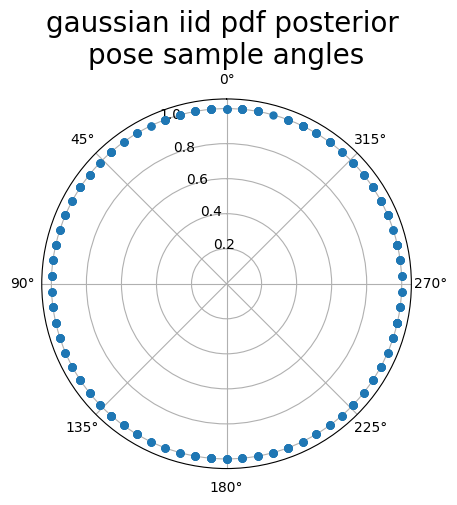

In [5]:
scores = []
for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:, None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )
    rendered_imgs = jnp.concatenate((rgb_ims, depth_ims[..., None]), axis=3)

    scores_batch, _ = gaussian_iid_pix_likelihood_vec(
        gt_img, rendered_imgs, gaussian_iid_pix_likelihood_args
    )
    # scores_batch, _ = threedp3_gmm_likelihood_vec(gt_img, rendered_imgs,  threedp3_gmm_likelihood_args)
    # scores_batch, _ = kray_likelihood_intermediate_vec(gt_img, rendered_imgs,  kray_likelihood_args)
    scores.append(scores_batch)

scores = jnp.concatenate(scores)
samples = jax.random.categorical(key, scores, shape=(num_samples,))

samples_deg_range = jnp.rad2deg(
    (jnp.max(delta_cps[samples], axis=0) - jnp.min(delta_cps[samples], axis=0))[2]
)
angles = delta_cps[samples][..., 2]

ax = plt.subplot(1, 1, 1, projection="polar")
ax.plot(angles, jnp.ones(angles.shape), linestyle="None", markersize=10.0, marker=".")
ax.set_theta_offset(jnp.pi / 2.0)
plt.title("gaussian iid pdf posterior \npose sample angles", fontsize=20)

Text(0.5, 1.0, '3dp3 pdf posterior \npose sample angles')

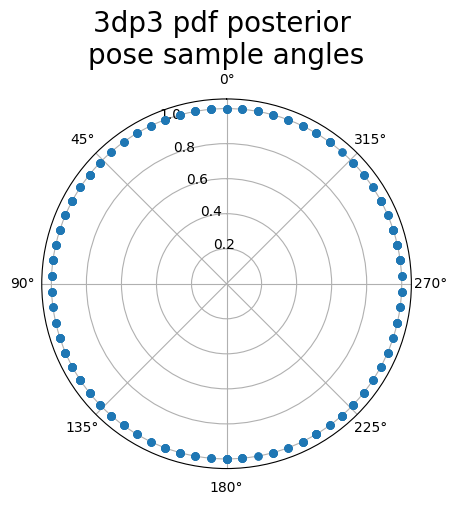

In [6]:
scores = []
for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:, None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )
    rendered_imgs = jnp.concatenate((rgb_ims, depth_ims[..., None]), axis=3)

    scores_batch, _ = threedp3_gmm_likelihood_vec(
        gt_img, rendered_imgs, threedp3_gmm_likelihood_args
    )
    scores.append(scores_batch)

scores = jnp.concatenate(scores)
samples = jax.random.categorical(key, scores, shape=(num_samples,))

samples_deg_range = jnp.rad2deg(
    (jnp.max(delta_cps[samples], axis=0) - jnp.min(delta_cps[samples], axis=0))[2]
)
angles = delta_cps[samples][..., 2]

ax = plt.subplot(1, 1, 1, projection="polar")
ax.plot(angles, jnp.ones(angles.shape), linestyle="None", markersize=10.0, marker=".")
ax.set_theta_offset(jnp.pi / 2.0)
plt.title("3dp3 pdf posterior \npose sample angles", fontsize=20)

Text(0.5, 1.0, 'surface ray (uniform volume outlier) pdf posterior \npose sample angles')

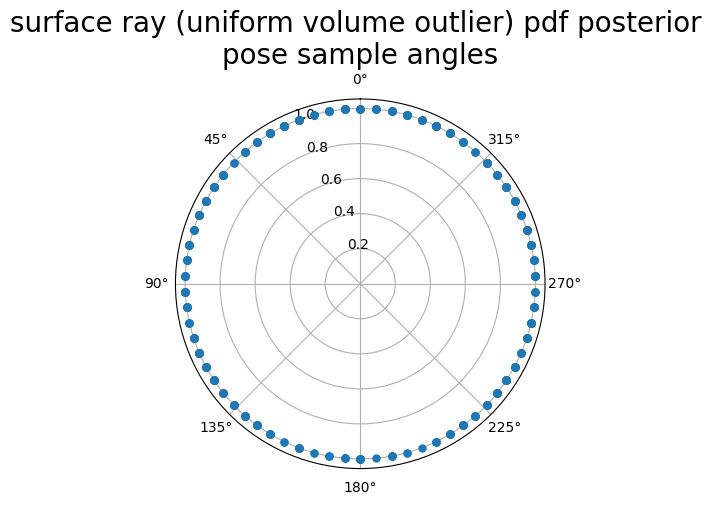

In [7]:
scores = []
for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:, None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )
    rendered_imgs = jnp.concatenate((rgb_ims, depth_ims[..., None]), axis=3)

    scores_batch, _ = kray_likelihood_intermediate_vec(
        gt_img, rendered_imgs, kray_likelihood_args
    )
    scores.append(scores_batch)

scores = jnp.concatenate(scores)
samples = jax.random.categorical(key, scores, shape=(num_samples,))

samples_deg_range = jnp.rad2deg(
    (jnp.max(delta_cps[samples], axis=0) - jnp.min(delta_cps[samples], axis=0))[2]
)
angles = delta_cps[samples][..., 2]

ax = plt.subplot(1, 1, 1, projection="polar")
ax.plot(angles, jnp.ones(angles.shape), linestyle="None", markersize=10.0, marker=".")
ax.set_theta_offset(jnp.pi / 2.0)
plt.title(
    "surface ray (uniform volume outlier) pdf posterior \npose sample angles",
    fontsize=20,
)

In [8]:
alternate_camera_pose = Pose.from_position_and_target(
    jnp.array([0.01, 0.000, 0.9]), object_pose.pos
)
alternate_view_images, _ = renderer.render_attribute_many(
    (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

original_view_images, original_view_depths = renderer.render_attribute_many(
    (camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

rendered_imgs = jnp.concatenate(
    (original_view_images, original_view_depths[..., None]), axis=3
)

# _, pixel_scores = gaussian_iid_pix_likelihood_vec(gt_img, rendered_imgs,  likelihood_args)
# _, pixel_scores = threedp3_gmm_likelihood_vec(gt_img, rendered_imgs,  likelihood_args)
_, pixel_scores = kray_likelihood_intermediate_vec(
    gt_img, rendered_imgs, kray_likelihood_args
)


PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

for t in range(len(alternate_view_images)):
    rr.set_time_sequence("time", t)
    rr.log(f"samples/alternate_view", rr.Image(alternate_view_images[t]))
    rr.log(
        f"samples/original_view",
        rr.Image(
            (
                original_view_images[t] * 0.7
                + (gt_img.sum(axis=2) > 0)[..., None] * jnp.ones(3)[None, None, :] * 0.3
            )
        ),
    )

    pixel_im = pixel_scores["pix_score"][t]
    cmap = matplotlib.colormaps["inferno"]
    norm = matplotlib.colors.Normalize(vmin=pixel_im.min(), vmax=pixel_im.max())
    rr.log(f"samples/heatmap", rr.Image(cmap(norm(pixel_im))))

In [9]:
alternate_view_image, _ = renderer.render_attribute(
    (alternate_camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

original_view_image, _ = renderer.render_attribute(
    (camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

(-0.5, 99.5, 99.5, -0.5)

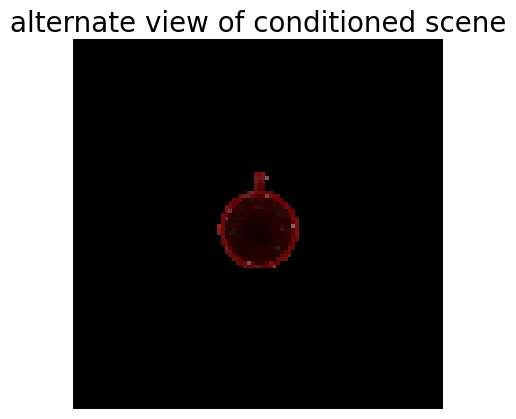

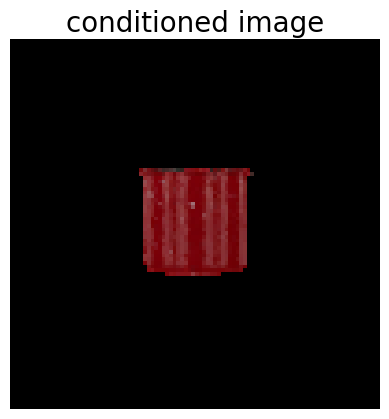

In [10]:
plt.figure()
plt.title("alternate view of conditioned scene", fontsize=20)
plt.imshow(alternate_view_image)
plt.axis("off")

plt.figure()
plt.title("conditioned image", fontsize=20)
plt.imshow(original_view_image)
plt.axis("off")